# Calculate forecasted and realtime return periods

This notebook derives near-realtime and forecasted return periods for gauges of interest.

This is for demonstration purposes only and not for operational decision making.



### Import Modules

In [1]:
from pathlib import Path
import pandas as pd
import yaml
from matplotlib import pyplot as plt
import sys
sys.path.append('../scripts')
from hydrograph_plotting import plot_detailed_hydrograph
from nsrps_data_access import bias_correct_forecast
from calculate_return_periods import calculate_return_periods, plot_exceedance

# add autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

### Read settings from configuration file

In [2]:
config_file = "../settings/general_settings.yaml"

# Read settings from yaml file
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

# Set variables, this can be replaced by a config file. To be discussed
api_url = config['msc_open_data_settings']['api_url']

# Set up paths 
gis_data_dir = config['paths']['gis_data']
output_base_dir = Path(config['paths']['output_dir'])
output_base_dir.mkdir(parents=True, exist_ok=True)
output_base_dir = output_base_dir.resolve()

# Set up paths to gis data
stations_csv = Path(gis_data_dir, config['gis_data']['hydro_stns_csv'])
nsrps_station_location_csv = Path(gis_data_dir, config['gis_data']['nsrps_stns_csv'])
watershed_shp = Path(gis_data_dir, config['gis_data']['basins_shp'])
flowlines_shp = Path(gis_data_dir, config['gis_data']['flowlines_shp'])

# Read in the list of hydrometric stations
hydro_stations_df = pd.read_csv(stations_csv)
search_stations = hydro_stations_df["ID"].tolist()

### Plot real time and forecasted data, relative to derived return periods

In [3]:
variable = 'DISCHARGE'
station = '05BB001'
bias_correct = True

output_return_period_dir = Path(output_base_dir, 'observed_and_forecasted_return_periods')
output_return_period_dir.mkdir(parents=True, exist_ok=True)

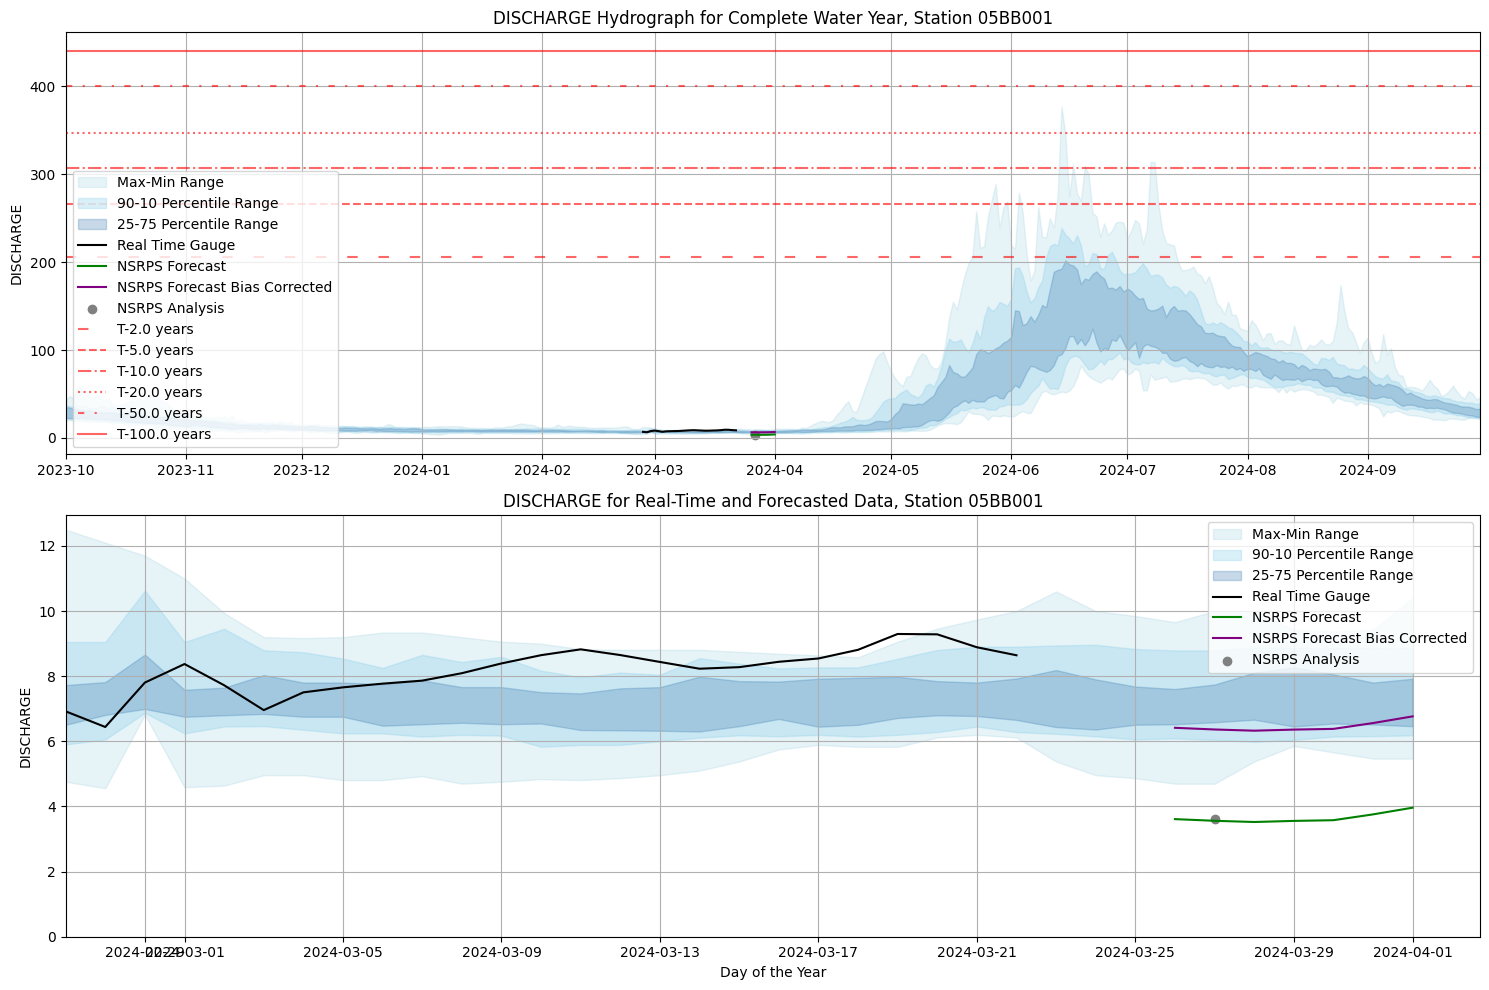

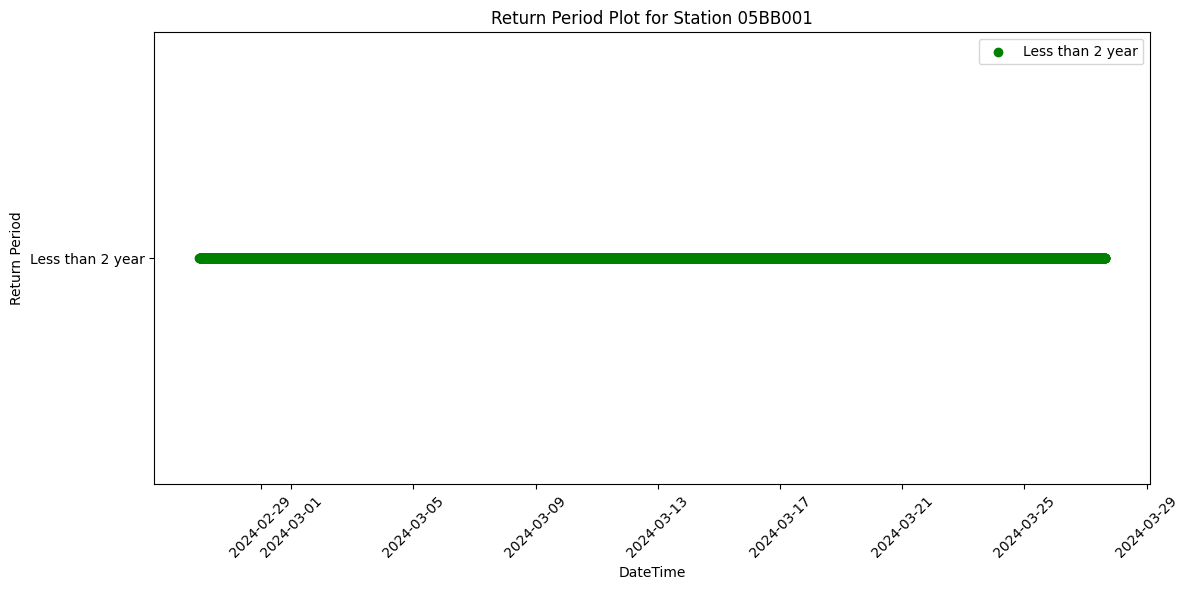

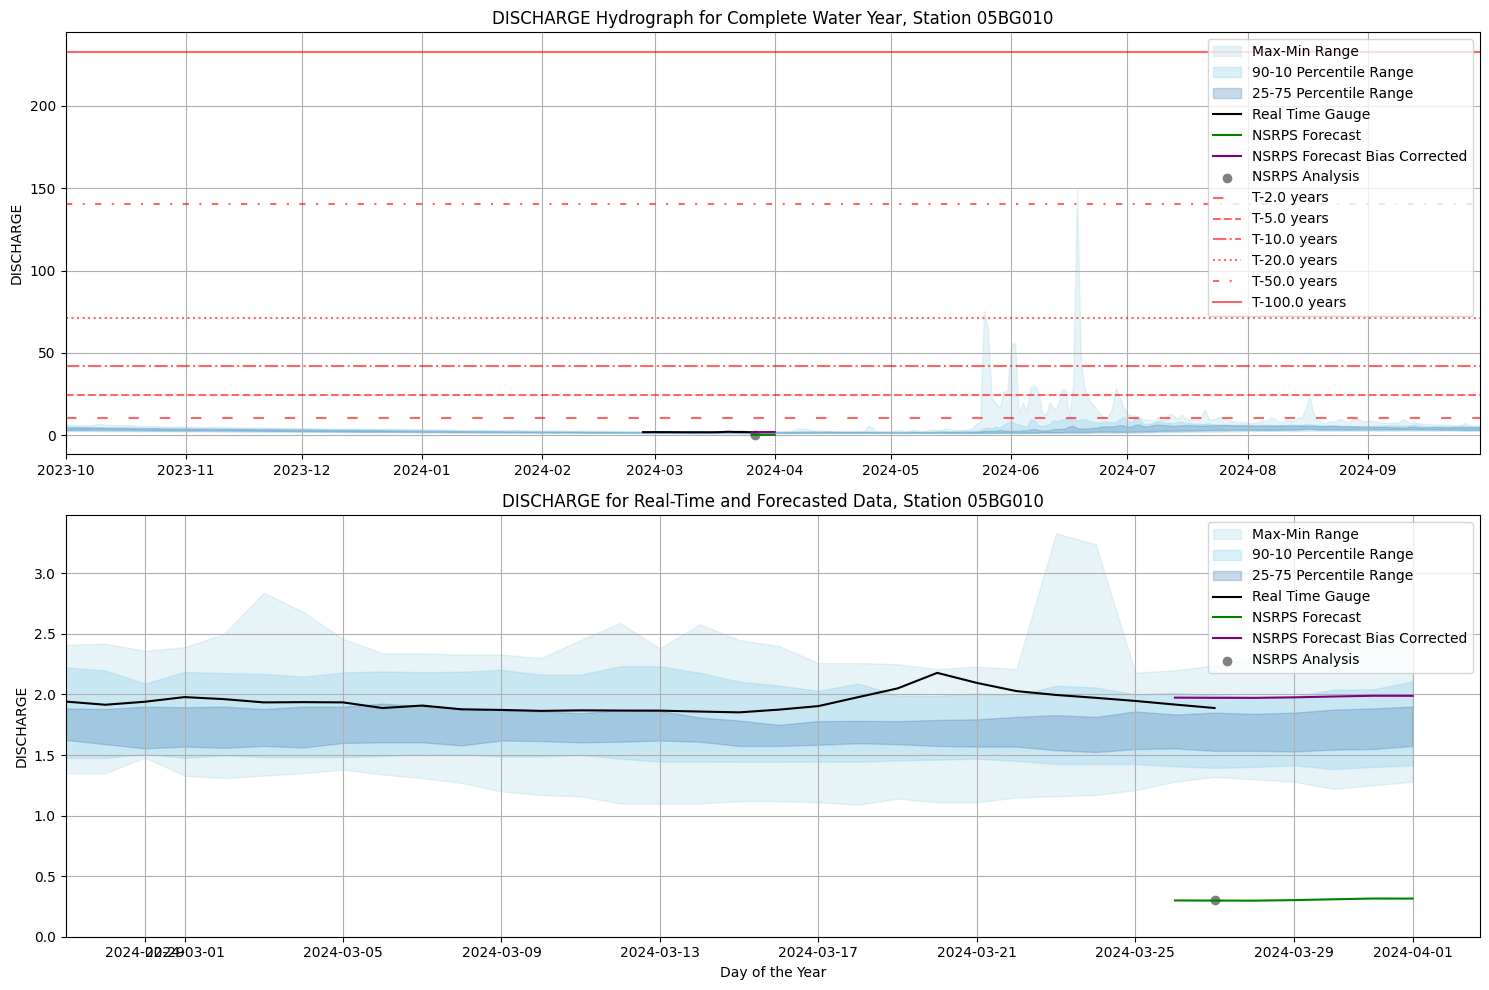

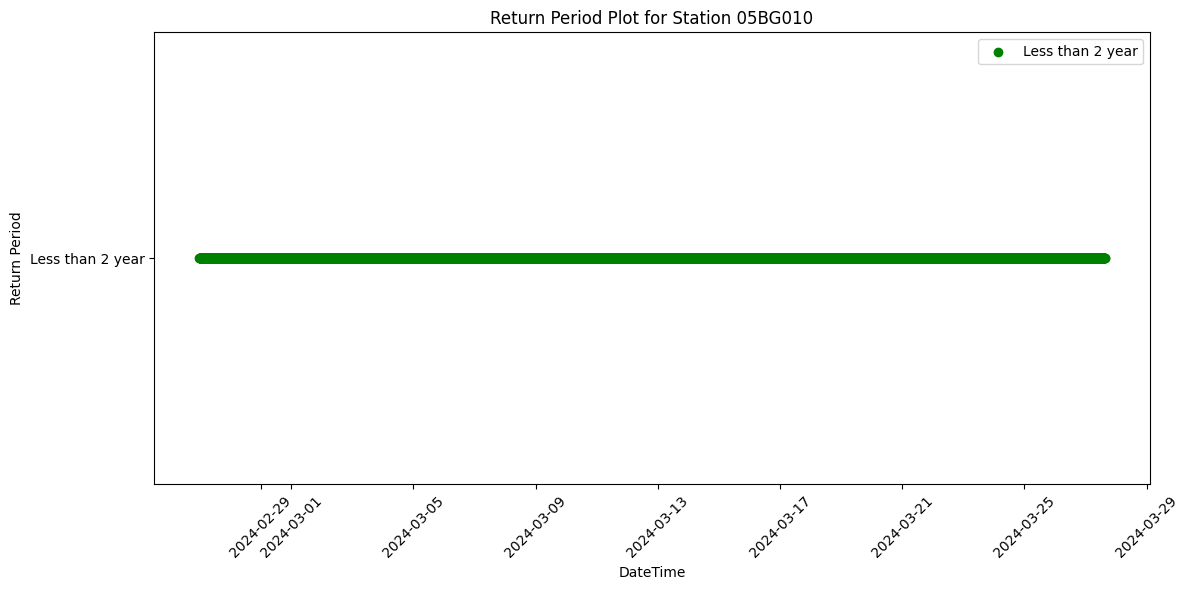

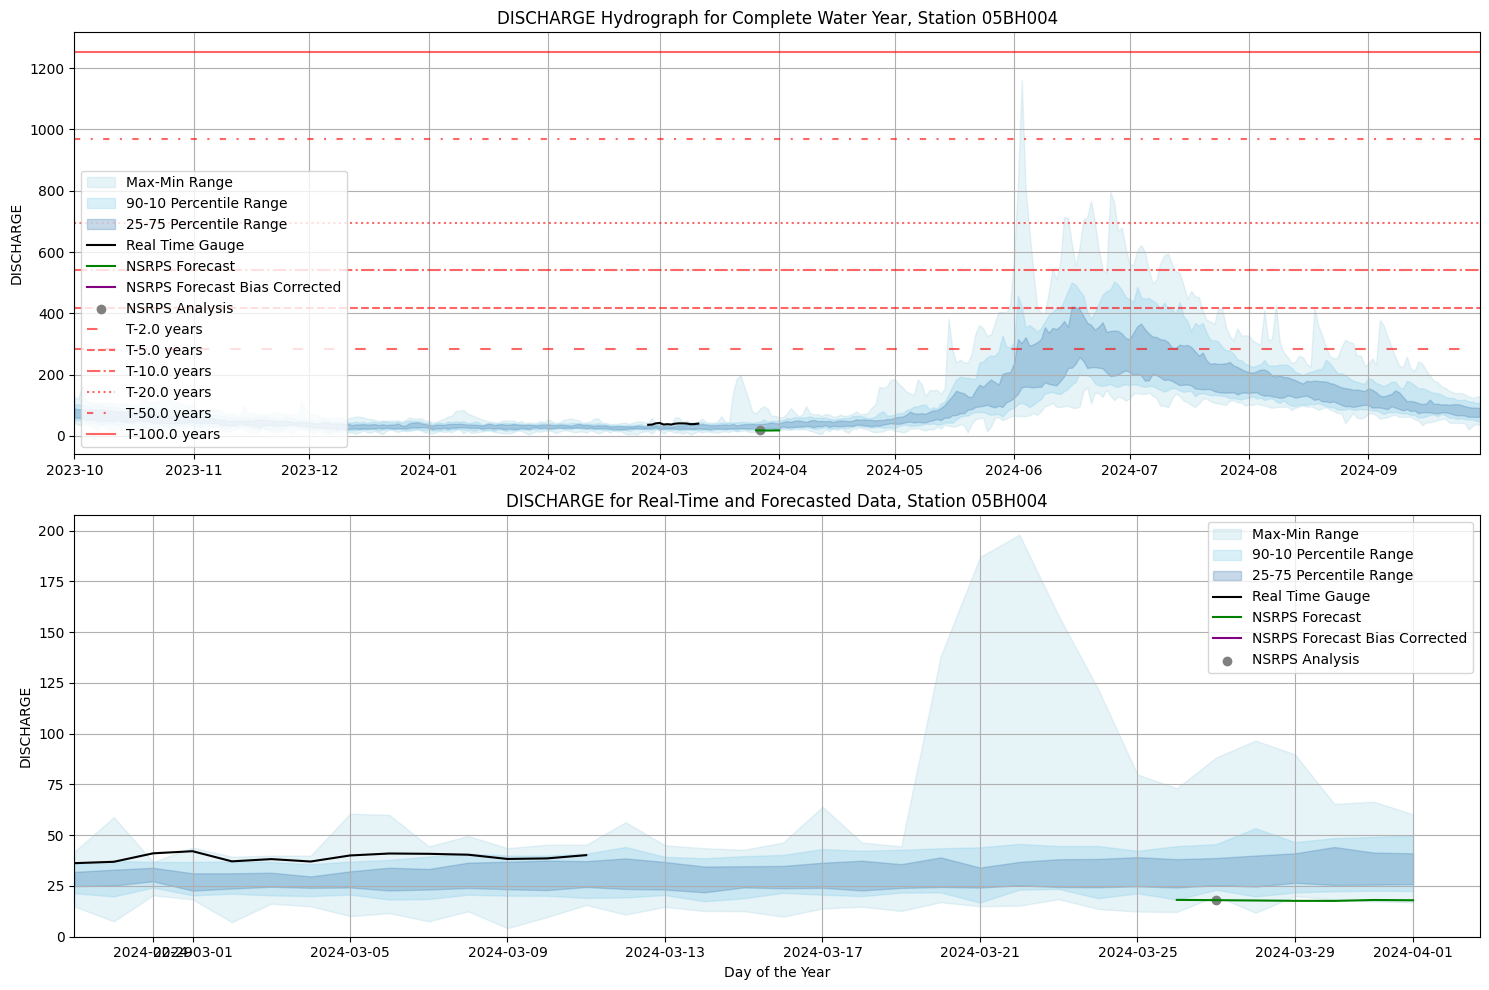

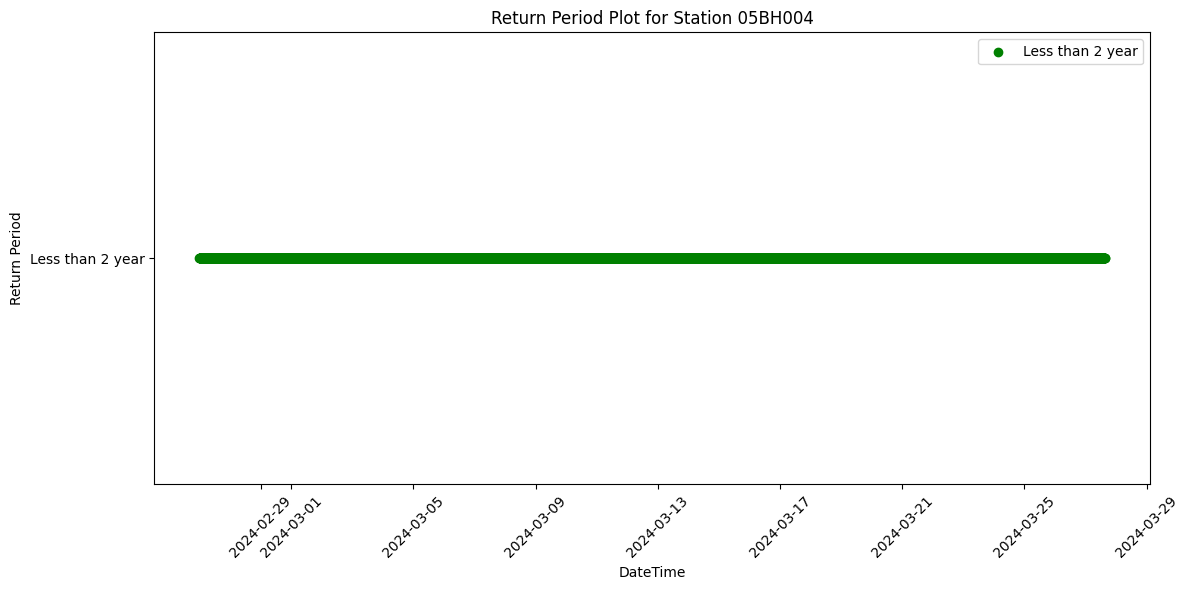

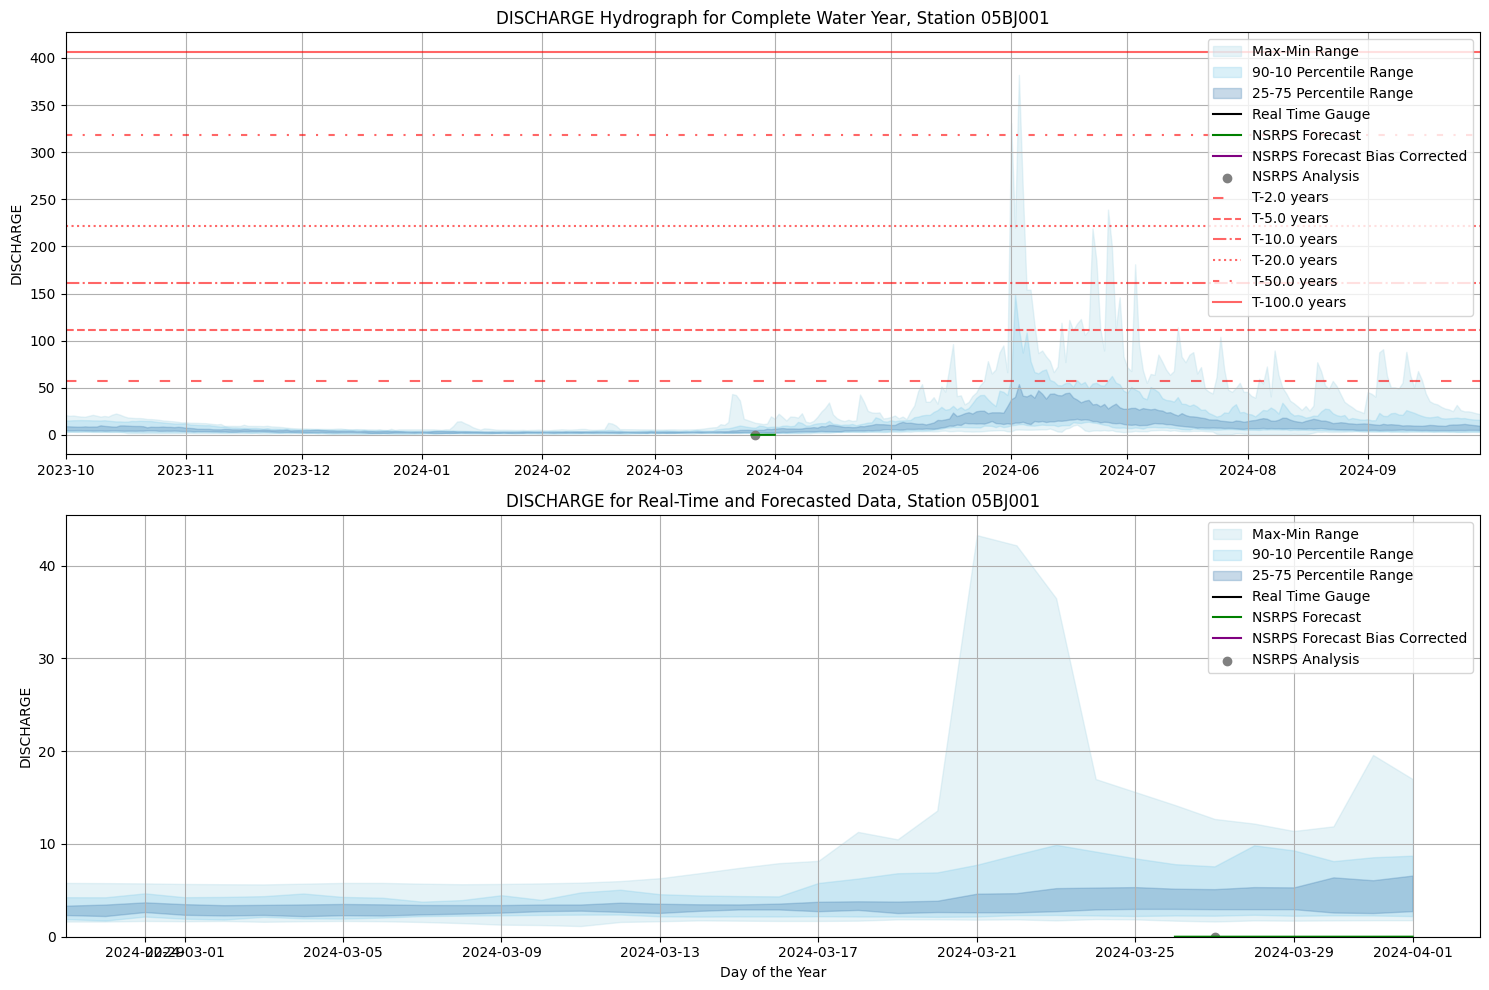

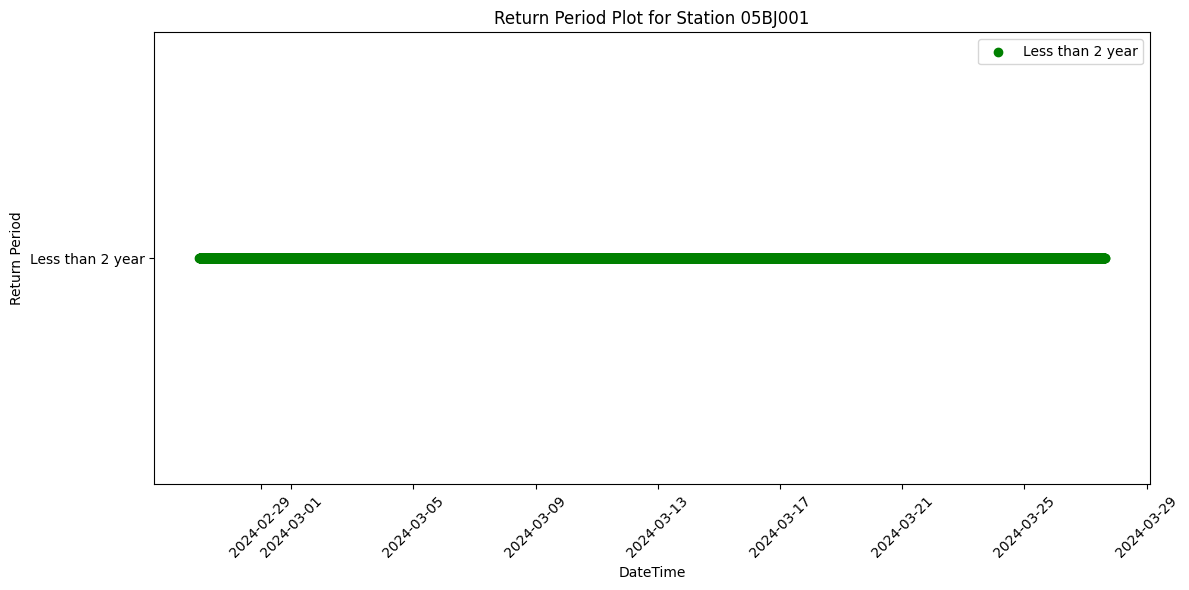

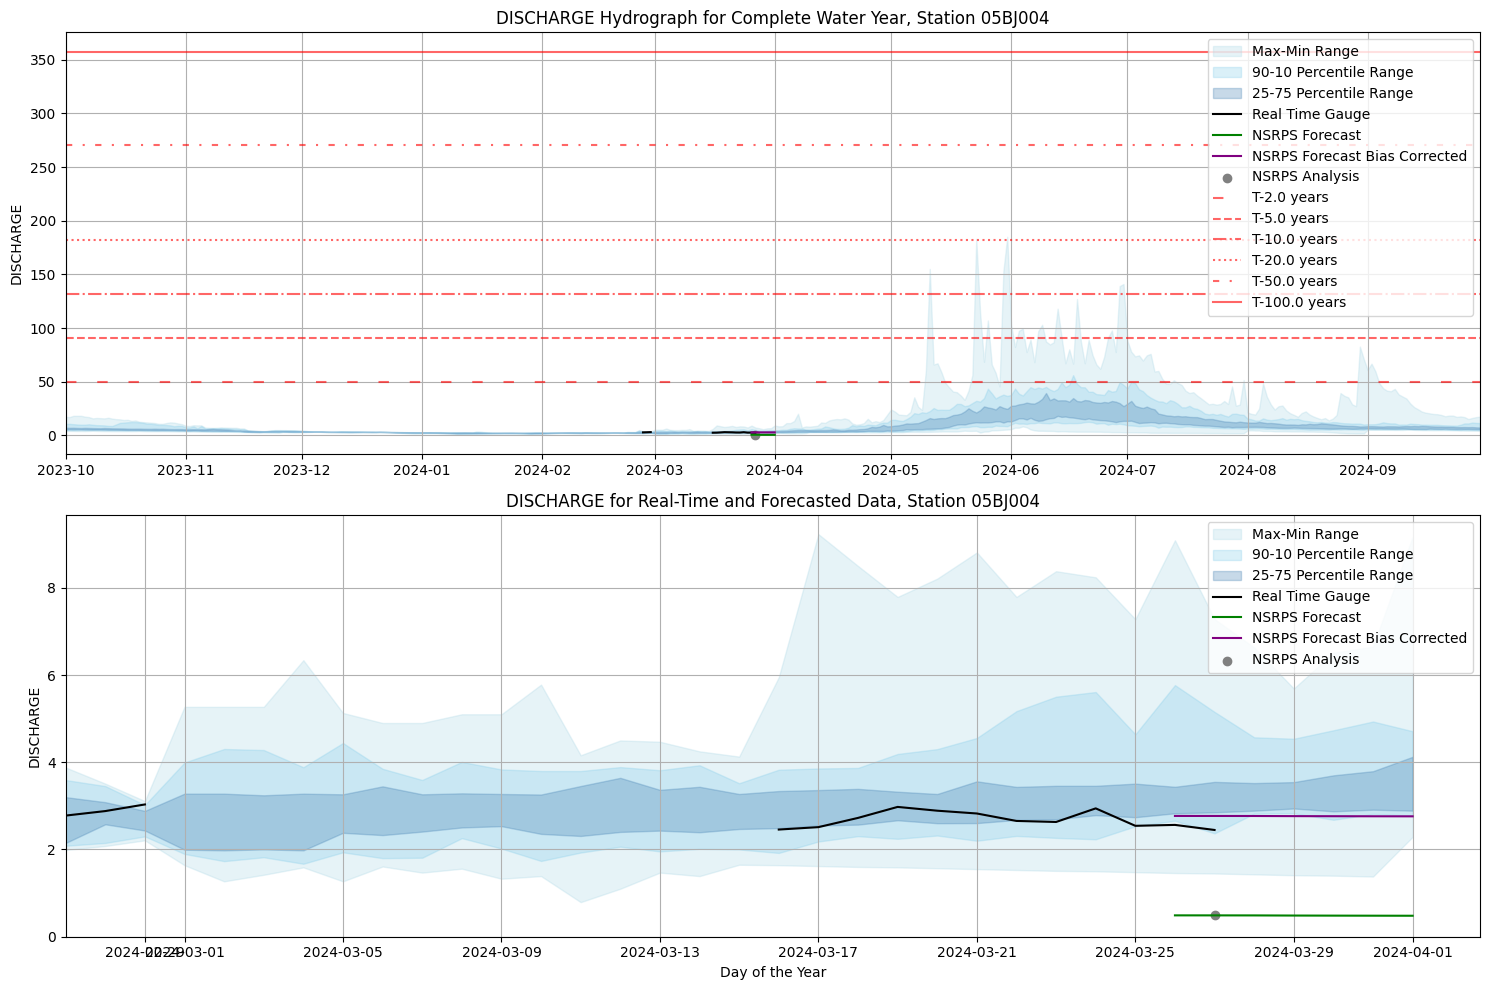

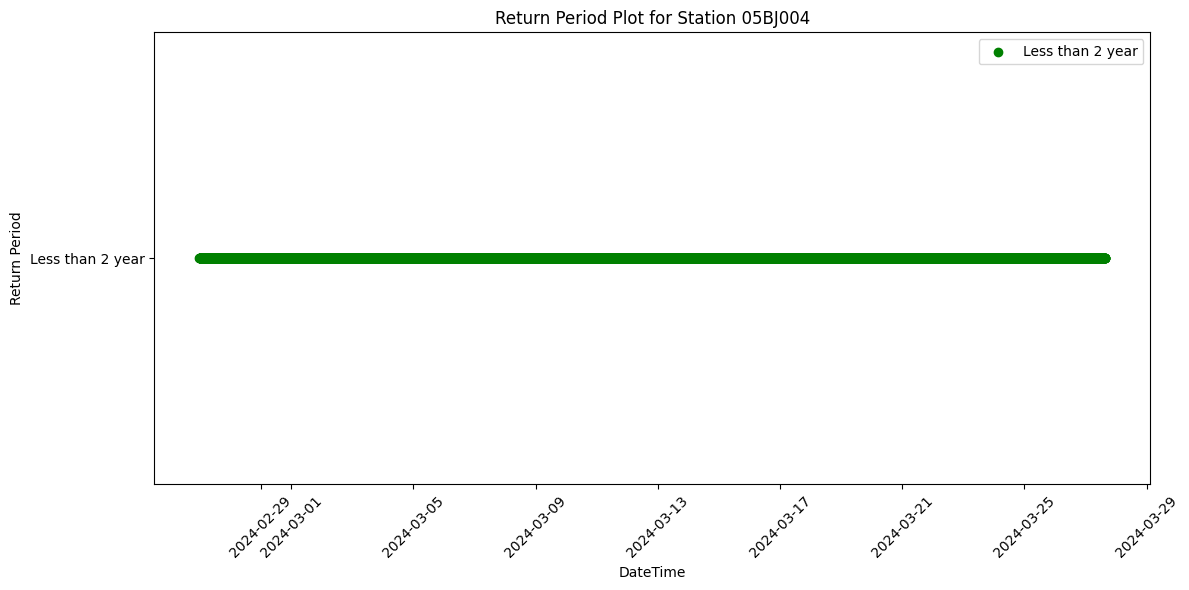

In [4]:
real_time_level_stations = search_stations
historic_level_stations = search_stations

for station_id in real_time_level_stations:
    if station_id not in historic_level_stations:
        continue

    historic_df = pd.read_csv(Path(output_base_dir,f'hydrometric-daily-mean/{station_id}_{variable}.csv'))
    realtime_df = pd.read_csv(Path(output_base_dir,f'hydrometric-realtime/{station_id}_{variable}.csv'))
    forecast_df = pd.read_csv(Path(output_base_dir,f'DHPS_1km_RiverDischarge/{station_id}_forecast.csv'))
    analysis_df = pd.read_csv(Path(output_base_dir,f'DHPS-Analysis_1km_RiverDischarge/{station_id}_analysis.csv'))
    threshold_csv = Path(output_base_dir, f'../flood_frequency_analysis/ffa_summary_for_tool.csv').resolve()
    threshold_df = pd.read_csv(threshold_csv)

    if bias_correct:
        forecast_bias_corrected_df = bias_correct_forecast(realtime_df, forecast_df)
        #calc_and_output_return_periods(realtime_df,forecast_bias_corrected_df, station_id, threshold_df, forecast_bias_corrected_df, output_return_period_dir)
    else:
        forecast_bias_corrected_df = None
        #calc_and_output_return_periods(realtime_df,forecast_df, station_id, threshold_df, forecast_bias_corrected_df, output_return_period_dir)

    plot_detailed_hydrograph(station_id,variable, historic_df, realtime_df, forecast_df, analysis_df,threshold_df,forecast_bias_corrected_df)

    return_level_df = calculate_return_periods(realtime_df, forecast_df, threshold_df, station_id)
    return_level_df.to_csv(Path(output_return_period_dir,f'{station_id}_return_periods.csv'))
    plot_exceedance(return_level_df, station_id)
    
    